# <center> 
# <center> 3c. AR(1) Application
## <center> ECO374

If using Colab, mount Google Drive and set path to files

In [1]:
import os
IN_COLAB = 'COLAB_GPU' in os.environ  
if IN_COLAB:
  from google.colab import drive; mount_path = '/content/drive'
  not os.path.ismount(mount_path) and drive.mount(mount_path)
  os.chdir('/content/drive/MyDrive/Colab Notebooks/Python_code') # Set Python file directory

Set up R for Python

In [2]:
import R_for_Python_setup as RPY
RPY.setup_R()
ro, pandas2ri, StrVector = RPY.initialize_rpy2()
%load_ext rpy2.ipython

R installed
Operating system: Windows
Development tool: Anaconda


Load R packages

In [3]:
R_packages = ['forecast']
RPY.load_R_packages(R_packages)

R packages loaded: forecast


Load Python packages

In [4]:
pth_packages = ['pandas_datareader']
import subprocess, sys
for pkg in pth_packages: subprocess.run([sys.executable, '-m', 'pip', 'install', pkg, '--quiet'], check=True)
import numpy as np, pandas as pd, pandas_datareader.data as web, datetime as dt
import matplotlib.pyplot as plt, matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 1. Data
U.S. monthly unemployment rate, %, seasonally adjusted ([Source](https://fred.stlouisfed.org/series/UNRATE))

In [5]:
unp = web.DataReader('UNRATE', 'fred', start=dt.datetime(2014,1,1), end=dt.datetime(2025,1,1)) 
unp = unp.asfreq('MS') # set to monthly frequency ('MS' = Month Start)

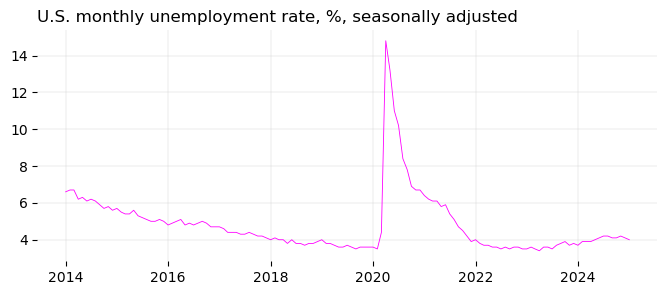

In [6]:
plt.figure(figsize=(8, 3))
plt.plot(unp, '-', color='magenta', linewidth=0.6)
plt.title('U.S. monthly unemployment rate, %, seasonally adjusted', loc='left')
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)
plt.show()

.

# 2. ACF and PACF

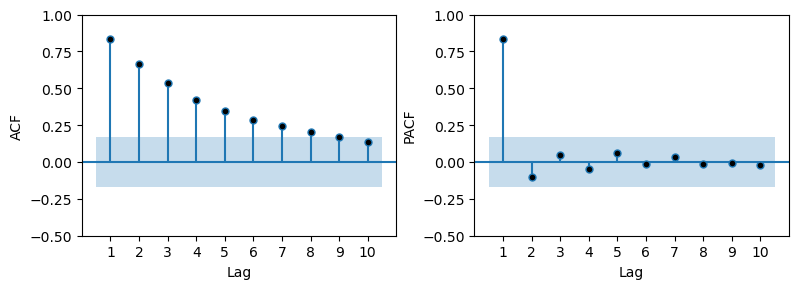

In [7]:
lag_max = 10

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axs = axs.flatten()

plot_acf(unp, lags=lag_max, alpha=0.05, zero=False, mfc='black', 
         bartlett_confint=False, title=None, ax=axs[0])
axs[0].set_ylabel('ACF')

plot_pacf(unp, lags=lag_max, alpha=0.05, zero=False, mfc='black', 
          title=None, ax=axs[1])
axs[1].set_ylabel('PACF')

for ax in axs:
    ax.set_ylim(-0.5,1)
    ax.set_xticks(np.arange(1, lag_max+1, step=1))
    ax.set_xlabel('Lag')

fig.tight_layout() 
plt.show() 

The data has PACF with 1 significant lag, while its ACF is decreasing towards zero more slowly. This pattern of dependence in the data matches well with the theoretical properties of the AR(1) process, which indicates that the data generating process can be well approximated with the AR(1) model.

# 3. ARMA automatic model selection
In addition to the insights into the data dynamics provided by ACF and PACF, we will consult the `auto.arima()` function from the R package [forecast](https://pkg.robjhyndman.com/forecast/) to advise us on the [best-fitting](https://otexts.com/fpp2/arima-r.html) ARMA model for the data based on AIC minimization among many types of ARMA models.

In [8]:
ro.globalenv['unp'] = unp # copy data from Python to R

In [9]:
%%R
forecast::auto.arima(unp)

Series: unp 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1    mean
  0.8351  4.8465
  0.0467  0.4707

0.8753:  log likelihood = -179.45
AIC=364.9   AICc=365.09   BIC=373.57


The output confirms AR(1) as the best-fitting model for the series. 

# 4. AR(1) Model and forecast
Fit AR(1) model based on `auto.arima`

In [10]:
%%R
AR1_model <- stats::arima(unp, order=c(1,0,0), include.mean=TRUE)

Set the forecast time horizon for 12 months ahead

In [11]:
%%R
h_steps <- 12

Generate forecast

In [12]:
%%R
AR1_forecast <- stats::predict(AR1_model, n.ahead=h_steps)

In [13]:
AR1_forecast = ro.globalenv['AR1_forecast'] # copy data from R to Python
h_steps = int(ro.globalenv['h_steps'][0])

Create a time index for the forecast (see file "1c. Time Series in Python" for details)

In [14]:
id = unp.index # extract past time index from the data series
id_f = pd.date_range(start=id[-1]+pd.DateOffset(1), 
                     periods=h_steps, freq=id.freq) # create future index
AR1_f = pd.DataFrame(index=id_f, data={'forecast': AR1_forecast[0]})

Plot part of the original series and the forecast (see file "1d. Graphics in Python" for details)

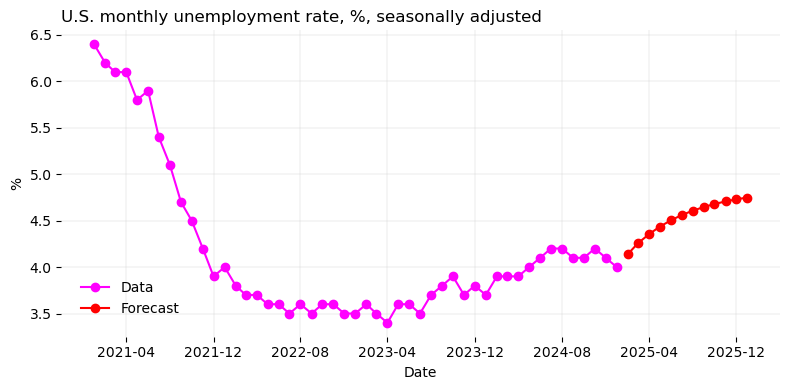

In [15]:
start_plot = pd.to_datetime('2021-01-01') # starting date for data plot
unp_s = unp[unp.index >= start_plot] # extract subset of data for plotting

plt.figure(figsize=(8, 4))
# plot data
plt.plot(unp_s.index, unp_s['UNRATE'], label='Data', color='magenta', linestyle='-', marker='o')
# plot forecast
plt.plot(AR1_f.index, AR1_f['forecast'], label='Forecast', color='red', linestyle='-', marker='o')

plt.xlabel('Date')
plt.ylabel('%')
plt.title('U.S. monthly unemployment rate, %, seasonally adjusted', loc='left')
plt.legend(loc=(0.02, 0.05), frameon=False) 
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=8)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.show()

 Plot subset of data and 1-step ahead in-sample forecasts

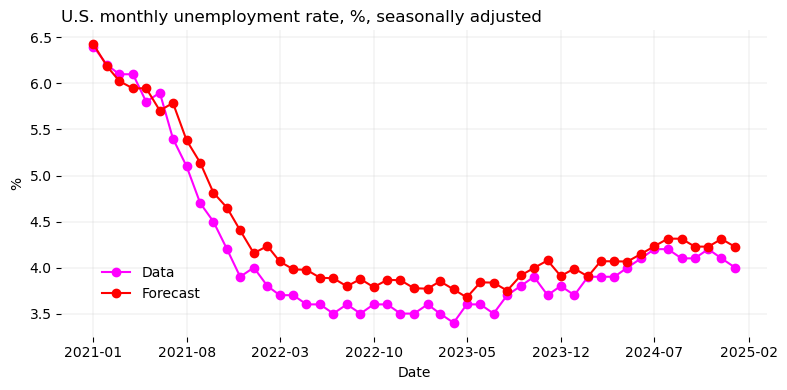

In [16]:
data = unp
f_start = pd.to_datetime('2021-01-01')
T = len(data)
y = data[data.index >= f_start].copy()
s = len(y)
y['y.hat'] = 0.

for j in range(s):
    t = T-s+j
    ydat = data.iloc[:t]      
    ro.globalenv['ydat'] = ydat # copy data from Python to R
    ro.r('''
    yh <- stats::predict(stats::arima(ydat, order=c(1,0,0), include.mean=TRUE), n.ahead=1)
    ''')
    yh = ro.globalenv['yh'] # copy data from R to Python    
    y.at[y.index[j], 'y.hat'] = yh[0]

plt.figure(figsize=(8, 4))
# plot data
plt.plot(y.index, y['UNRATE'], label='Data', color='magenta', linestyle='-', marker='o')
# plot forecast
plt.plot(y.index, y['y.hat'], label='Forecast', color='red', linestyle='-', marker='o')

plt.xlabel('Date')
plt.ylabel('%')
plt.title('U.S. monthly unemployment rate, %, seasonally adjusted', loc='left')
plt.legend(loc=(0.05, 0.1), frameon=False) 
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.show()